# Colab Cells

In [1]:
#Run this cell to install Tensorflow GPU 2.0

!pip install tensorflow-gpu==2.0.0.beta0

     |████████████████████████████████| 348.9MB 46kB/s 
     |████████████████████████████████| 3.1MB 49.4MB/s 
     |████████████████████████████████| 501kB 41.4MB/s 


In [0]:
#Get your Kaggle API key and upload to your colab workspace
#It is expected to be named kaggle.json
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

In [3]:
#Download the competition data

!kaggle competitions download -c ammi-bootcamp-kaggle-competition

 37% 9.00M/24.2M [00:00<00:00, 18.1MB/s]
100% 24.2M/24.2M [00:00<00:00, 44.9MB/s]
  0% 0.00/720k [00:00<?, ?B/s]
100% 720k/720k [00:00<00:00, 90.7MB/s]
 43% 5.00M/11.6M [00:00<00:00, 18.3MB/s]
100% 11.6M/11.6M [00:00<00:00, 33.2MB/s]


In [4]:
#Unzip the data 

!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


# Begin here if you are not working on Colab

In [0]:
test_path = '/content/test.csv'  
train_path = '/content/train.csv' 

In [0]:
#Import all necessary libraries

import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import datasets, preprocessing, models, layers
from tensorflow import keras
from tensorflow.keras import layers


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [0]:
#Read in the data into a Pandas DataFrame

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [26]:
#Visualize the data

train_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,id
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,PORTUGUESE RED,J. Portugal Ramos,32027
1,France,"A solid, chunky wine, with a structure that is...",NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,71079
2,France,"This is powerful and concentrated, with the hi...",NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,BORDEAUX-STYLE RED BLEND,Château Figeac,32440
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,PETITE SIRAH,Jaffurs,124405
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,ROSé,Syncline,33649


In [0]:
#Fetch out required columns from data

train_data = train_data[['description', 'points', 'price', 'province', 'variety', 'winery', 'id', 'country', 'region_1', 'region_2', 'designation']]
test_data = test_data[['description', 'points', 'price', 'province', 'variety', 'winery', 'id', 'country', 'region_1', 'region_2', 'designation']]

In [0]:
#Values to be filled into empty field in each columns

values = {'country':'US', 'province':'California', 'variety':'PINOT NOIR', 'region_1':'_', 'region_2':'_', 'designation':'_'}

In [0]:
#Fill in missing columns

train_data.fillna(value=values, inplace=True)
test_data.fillna(value=values, inplace=True)

# Make sense of description information

In [0]:
#Regex expression for cleaning text data

import re

def strip_special_chars(st):
    my_pattern = '[A-Za-z0-9./ ]+'
    return (''.join(re.findall(my_pattern, st))).lower()

    

In [31]:
#Fetch out description text
train_description_data = train_data['description']
test_description_data = test_data['description']


#strip special characters and convert to lower case
train_description_data = train_description_data.map(strip_special_chars)
test_description_data = test_description_data.map(strip_special_chars)

complete_text = pd.concat([train_description_data, test_description_data])
complete_text.describe()

count                                                258210
unique                                               156622
top       with its soft acidity silky mouthfeel and very...
freq                                                      6
Name: description, dtype: object

In [33]:
#Create a vocabulary from the description text 

tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()

for text in complete_text:
  some_tokens = tokenizer.tokenize(text)
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size


54245

In [0]:
#Instantiate an encoder on the vocabulary set

description_encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [0]:
def description_encode(raw_text):
  encoded_text = description_encoder.encode(raw_text)
  return encoded_text


In [0]:
#Dictionary of Encoders for each Categorical Column

encoders = {}

for i in ['province', 'variety', 'winery', 'country', 'region_1', 'region_2', 'designation']:
  complete_column = pd.concat([train_data[i], test_data[i]])
  encoders[i] = LabelEncoder().fit(complete_column)
                              
complete_points_column = pd.concat([train_data['points'], test_data['points']]).values.reshape(-1,1)

#Points Scaler
points_scaler = StandardScaler().fit(complete_points_column)

#Defining Model Architecture

In [0]:
#Model Architecture

#Inputs to the model
cat_counts = {'country':48, 'winery': 18158, 'variety':745, 'province':483, 'region_1':1308, 'region_2':19, 'designation':44390 }

#Number of unique categories per feature
description_input = keras.Input(shape=(None,), name='description')
country_input = keras.Input(shape=(1,), name='country')
province_input = keras.Input(shape=(1,), name='province')
winery_input = keras.Input(shape=(1,), name='winery')
variety_input = keras.Input(shape=(1,), name='variety')
points_input = keras.Input(shape=(1,), name='points')
region_1_input = keras.Input(shape=(1,), name='region_1')
region_2_input = keras.Input(shape=(1,), name='region_2')
designation_input = keras.Input(shape=(1,), name='designation')

#Embed Sparse Inputs
country_features = keras.layers.Embedding(cat_counts['country'], 3)(country_input)
country_features = keras.layers.Reshape(target_shape=(3,))(country_features)

province_features = keras.layers.Embedding(cat_counts['province'], 5)(province_input)
province_features = keras.layers.Reshape(target_shape=(5,))(province_features)

winery_features = keras.layers.Embedding(cat_counts['winery'], 12)(winery_input)
winery_features = keras.layers.Reshape(target_shape=(12,))(winery_features)

variety_features = keras.layers.Embedding(cat_counts['variety'], 6)(variety_input)
variety_features = keras.layers.Reshape(target_shape=(6,))(variety_features)

region_1_features = keras.layers.Embedding(cat_counts['region_1'], 6)(region_1_input)
region_1_features = keras.layers.Reshape(target_shape=(6,))(region_1_features)

region_2_features = keras.layers.Embedding(cat_counts['region_2'], 3)(region_2_input)
region_2_features = keras.layers.Reshape(target_shape=(3,))(region_2_features)

designation_features = keras.layers.Embedding(cat_counts['designation'], 16)(designation_input)
designation_features = keras.layers.Reshape(target_shape=(16,))(designation_features)



description_features = keras.layers.Embedding(vocab_size+1, 64)(description_input)
#points_features = keras.layers.Reshape(target_shape=(1, 1))(points_input)

#Reduce Sequence of embedded words in description to a 128 dimensional vector
description_features = keras.layers.LSTM(128)(description_features)

#Merge all features together
x = keras.layers.concatenate([country_features, province_features, winery_features, variety_features, description_features, region_1_features, region_2_features, designation_features, points_input])
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
output = keras.layers.Dense(1, activation='linear', name='price')(x)

def create_model():
    x = keras.Model(inputs=[country_input, province_input, winery_input, variety_input, description_input, region_1_input, region_2_input, designation_input, points_input], outputs=output)
    x.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss='MSE', metrics=['mse'])
    return x

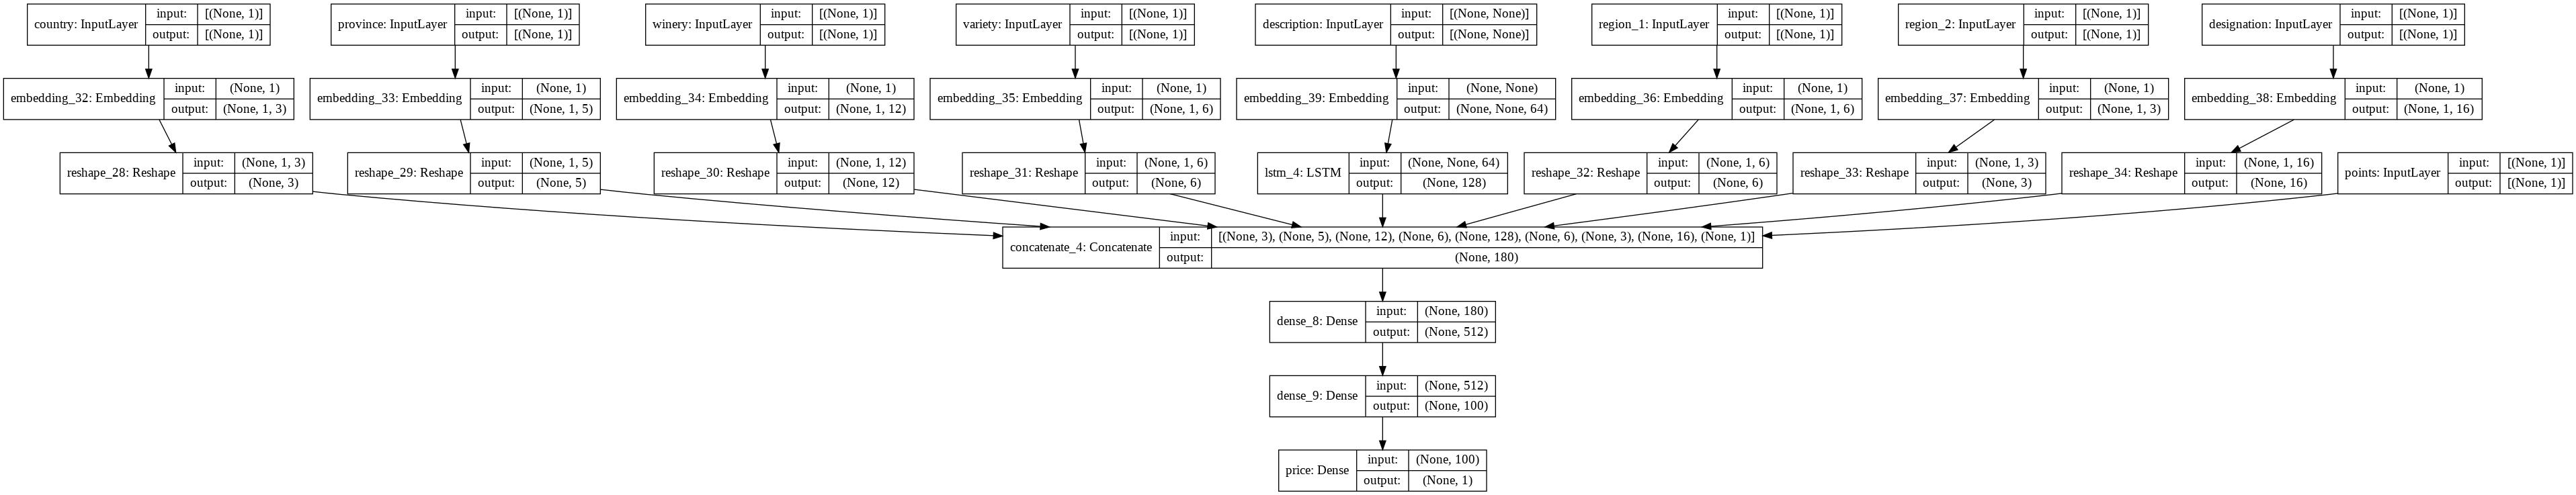

In [49]:
model = create_model()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [50]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
country (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
province (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
winery (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
variety (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [0]:
#Process input data

_train_data = train_data.sample(frac=0.9,random_state=0)
val_data = train_data.drop(_train_data.index)

def process_data(df):
  input_dictionary = {}
  label_dictionary = {}
  
  features = ['country', 'province', 'variety', 'winery', 'region_1', 'region_2', 'designation']
  for i in features:
    input_dictionary[i] = (encoders[i].transform(df[i])).reshape(-1,1)
  
  description_data = df['description'].map(strip_special_chars)
  input_dictionary['description'] = (description_data.map(description_encode))#.values.reshape(-1,1)
  input_dictionary['description'] = preprocessing.sequence.pad_sequences(input_dictionary['description'], maxlen=200)
  input_dictionary['description'] = map(lambda x: np.asarray(x), input_dictionary['description'])
  input_dictionary['description'] = np.asarray(list(input_dictionary['description']))
  input_dictionary['points'] = points_scaler.transform(df['points'].values.reshape(-1,1))
  
  label_dictionary['price'] = df['price'].values
  
  return input_dictionary, label_dictionary
  

In [0]:
#Splitting data
x_train, y_train = process_data(_train_data)
x_val, y_val = process_data(val_data)

x_test, y_test = process_data(test_data)

In [0]:
#Training

checkpoint_path = "./model.hdf5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

model = create_model()

train_history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val))


Train on 157500 samples, validate on 17500 samples
Epoch 1/10
 34816/157500 [=====>........................] - ETA: 14:57 - loss: 1063.7550 - mse: 1063.7554

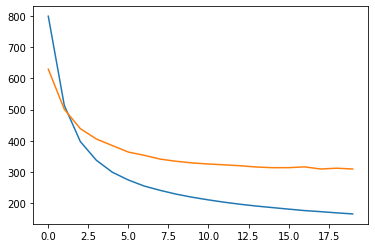

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.show()

In [0]:

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on validation data')
results = model.evaluate(x_val, y_val, batch_size=64)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test)


In [0]:
#Generate submission file from predictions

submission_file_name = 'wine_test.csv'

test_data['price'] = predictions
submission = test_data[['id', 'price']]
submission.head()
submission.to_csv(submission_file_name, index=False)